# Import Dependencies

We begin by importing the necessary libraries. 

In [1]:
# Web scraping
import requests

# Data analysis
import re
import pandas as pd
import geopandas as gpd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Web Scraping

Next, retrieve the Massachusetts county data from [Wikipedia](https://en.wikipedia.org/wiki/List_of_counties_in_Massachusetts).

In [3]:
# Scrape data from wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_counties_in_Massachusetts'
html = requests.get(url).content
df_list = pd.read_html(html)
df = df_list[1]

# Display first 5 rows
df.head()

,County,FIPS code[14],County seat[15],Est.[16],Origin[10],Etymology[11],Population[17],Area[16],Map
0,Barnstable County,1,Barnstable,1685,One of three original counties created in the ...,"After its county seat of Barnstable, which is ...",232411,"396 sq mi (1,026 km2)",NaN
1,Berkshire County,3,Pittsfield,1761,From part of Hampshire County. Government abol...,For the English county of Berkshire,128657,"931 sq mi (2,411 km2)",NaN
2,Bristol County,5,Taunton,1685,One of three original counties created in the ...,"For its original county seat of Bristol, Massa...",580164,"556 sq mi (1,440 km2)",NaN
3,Dukes County,7,Edgartown,1695,From Martha's Vineyard and the Elizabeth Islan...,"Formerly a part of Dukes County, New York unti...",21097,104 sq mi (269 km2),NaN
4,Essex County,9,"Salem, Lawrence",1643,One of four original counties created in the M...,For the English county of Essex,807074,"498 sq mi (1,290 km2)",NaN


# Preprocessing

Then, we perform the appropriate preprocessing steps. 

In [4]:
# Only keep relevant columns
df = df[['County', 'Population[17]', 'Area[16]']]

# Rename columns
df.columns = ['county', 'population', 'area']

# Extract square mileage from area column
df = df.copy()
def extract_sqmi(val):
    match = re.search(r'(\d+)\s+sq\s+mi', val)
    if match:
        return match.group(1)
    else:
        return None
df['area'] = df['area'].str.replace(',', '').apply(extract_sqmi).astype(int)

# Calculate population density
df['density'] = df['population'] / df['area']

# Display first 5 rows
df.head()

,county,population,area,density
0,Barnstable County,232411,396,586.896465
1,Berkshire County,128657,931,138.192266
2,Bristol County,580164,556,1043.460432
3,Dukes County,21097,104,202.855769
4,Essex County,807074,498,1620.630522


Also read in the Massachusetts county shapefiles from disk, and join it with `df` along the county names. 

In [5]:
# Read in shapefile
counties = gpd.read_file('../data/mass_counties/COUNTIES_POLYM.shp')

# Merge dataframes by county name
df['county'] = df['county'].apply(lambda x: x[:-7].lower())
counties['COUNTY'] = counties['COUNTY'].apply(lambda x: x.lower())
merged_data = counties.merge(df, left_on="COUNTY", right_on="county")

# Only keep relevant columns
merged_data = merged_data[['county', 'population', 'area', 'density', 'geometry']]

# Display first 5 rows
merged_data.head()

,county,population,area,density,geometry
0,berkshire,128657,931,138.192266,"POLYGON ((77140.460 940054.000, 77271.680 9400..."
1,bristol,580164,556,1043.460432,"MULTIPOLYGON (((241888.920 851747.060, 241922...."
2,dukes,21097,104,202.855769,"MULTIPOLYGON (((275042.500 803927.560, 275096...."
3,essex,807074,498,1620.630522,"MULTIPOLYGON (((242123.030 912106.690, 242151...."
4,barnstable,232411,396,586.896465,"MULTIPOLYGON (((306542.380 822469.130, 306590...."


# Data Visualization

It remains to create a choropleth map indicating population density by county. 

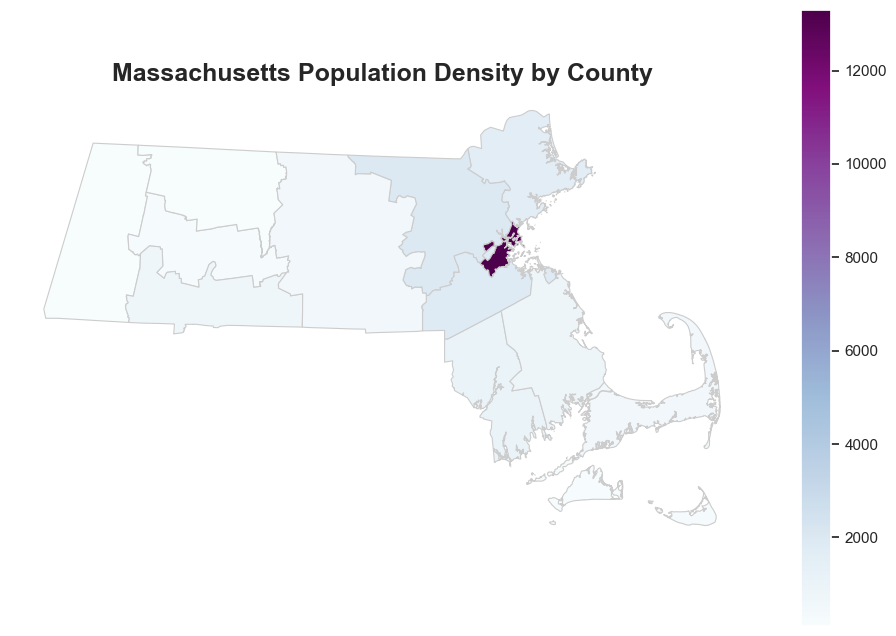

In [9]:
# Create choropleth map
fig, ax = plt.subplots(figsize=(12,8))
merged_data.plot(column='density', cmap='BuPu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.axis('off')
ax.set_title('Massachusetts Population Density by County', fontdict={'fontsize': '18', 'fontweight': 'bold'})

# Save & display results
plt.savefig('ma_county_density.png', format='png')
plt.show()